# Разработка A/B-тестирования и анализ результатов

- Автор: Щербань Сергей

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')
display(sessions_history.head())
sessions_history.info()
duplicates = sessions_history[sessions_history.duplicated()]
print("Количество дубликатов:", sessions_history.duplicated().sum())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 435924 entries, 0 to 435923
,Data columns (total 10 columns):
, #   Column             Non-Null Count   Dtype 
,---  ------             --------------   ----- 
, 0   user_id            435924 non-null  object
, 1   session_id         435924 non-null  object
, 2   session_date       435924 non-null  object
, 3   session_start_ts   435924 non-null  object
, 4   install_date       435924 non-null  object
, 5   session_number     435924 non-null  int64 
, 6   registration_flag  435924 non-null  int64 
, 7   page_counter       435924 non-null  int64 
, 8   region             435924 non-null  object
, 9   device             435924 non-null  object
,dtypes: int64(3), object(7)
,memory usage: 33.3+ MB
,Количество дубликатов: 0


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [2]:
# Группировка по user_id и подсчёт уникальных сессий
user_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique().reset_index(name='session_count')

# Находим пользователя с наибольшим количеством сессий
max_sessions_user = user_sessions_count.loc[user_sessions_count['session_count'].idxmax()]['user_id']

# Выводим данные для пользователя с наибольшим количеством сессий
selected_user_data = sessions_history[sessions_history['user_id'] == max_sessions_user]
display(selected_user_data.head(10))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

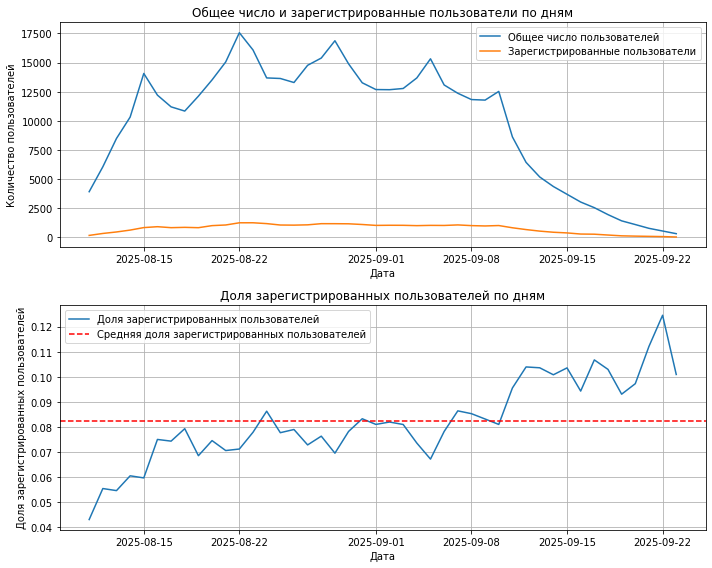

Количество уникальных пользователей: 435924
,Период подсчета количества регистраций: с 2025-08-11 по 2025-09-22 (42 дня)
,Среднее значение доли: 0.082
,Дата минимального значение доли: 2025-08-11
,Дата максимального значение доли: 2025-09-22


In [3]:
# Преобразование столбца с датой в datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Группировка по дате и подсчёт уникальных пользователей
daily_users = sessions_history.groupby(sessions_history['session_date'].dt.date)['user_id'].nunique().reset_index(name='unique_users')

# Проверка регистрации пользователей
daily_registered_users = sessions_history[sessions_history['registration_flag'] == True].groupby(sessions_history['session_date'].dt.date)['user_id'].nunique().reset_index(name='registered_users')

# Объединение данных
daily_data = daily_users.merge(daily_registered_users, on='session_date', how='left').fillna(0)

# Расчёт доли зарегистрированных пользователей
daily_data['registration_ratio'] = daily_data['registered_users'] / daily_data['unique_users']

# Расчёт средней доли зарегистрированных пользователей
average_registration_ratio = daily_data['registration_ratio'].mean()

# Подсчёт количества уникальных пользователей
unique_users_count = daily_data['unique_users'].sum()

# Находим минимальное и максимальное значения даты
min_date = daily_data['session_date'].min()
max_date = daily_data['session_date'].max()

# Находим минимальные и максимальные значения доли зарегистрированных пользователей
min_ratio = daily_data['registration_ratio'].min()
max_ratio = daily_data['registration_ratio'].max()

# Получаем даты, соответствующие минимальным и максимальным значениям
min_date = daily_data.loc[daily_data['registration_ratio'] == min_ratio, 'session_date'].iloc[0]
max_date = daily_data.loc[daily_data['registration_ratio'] == max_ratio, 'session_date'].iloc[0]

# Построение графиков
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# График общего числа пользователей и зарегистрированных пользователей
ax[0].plot(daily_data['session_date'], daily_data['unique_users'], label='Общее число пользователей')
ax[0].plot(daily_data['session_date'], daily_data['registered_users'], label='Зарегистрированные пользователи')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Количество пользователей')
ax[0].grid(True)
ax[0].legend()
ax[0].set_title('Общее число и зарегистрированные пользователи по дням')

# График доли зарегистрированных пользователей по дням
ax[1].plot(daily_data['session_date'], daily_data['registration_ratio'], label='Доля зарегистрированных пользователей')
ax[1].axhline(average_registration_ratio, color='red', linestyle='--', label='Средняя доля зарегистрированных пользователей')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Доля зарегистрированных пользователей')
ax[1].grid(True)
ax[1].legend()
ax[1].set_title('Доля зарегистрированных пользователей по дням')

plt.tight_layout()
plt.show()

# Отображение количества уникальных пользователей и период
print("Количество уникальных пользователей:", unique_users_count)
print(f"Период подсчета количества регистраций: с {min_date} по {max_date} ({(max_date - min_date).days} дня)")
print("Среднее значение доли:", round(average_registration_ratio,3))
print("Дата минимального значение доли:", min_date)
print("Дата максимального значение доли:", max_date)


#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

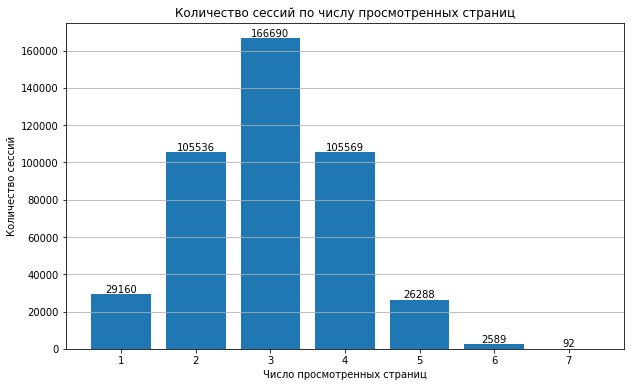

In [4]:
# Группировка по количеству просмотренных страниц
page_views_grouped = sessions_history.groupby('page_counter').size().reset_index(name='session_count')

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.bar(page_views_grouped['page_counter'], page_views_grouped['session_count'])

# Добавление подписей к столбцам
for i, v in enumerate(page_views_grouped['session_count']):
    plt.text(page_views_grouped['page_counter'][i], v, str(v), ha='center', va='bottom')

plt.title('Количество сессий по числу просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.show()


#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

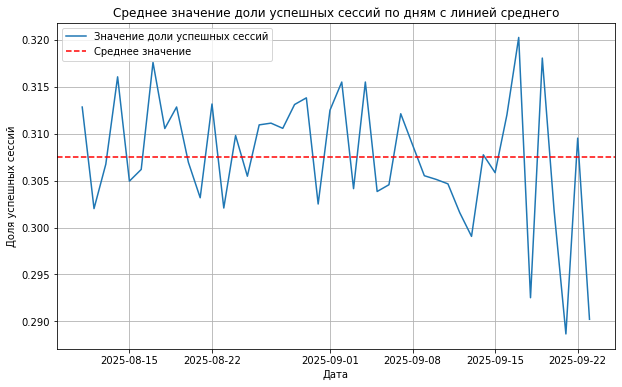

Стандартное отклонение: 0.007
,Среднее за весь период: 0.308
,Среднее за последний период: 0.303


In [5]:
# Создание столбца good_session
sessions_history["good_session"] = np.where(sessions_history["page_counter"] >= 4, 1, 0)

# Группировка по дате и расчёт среднего значения доли успешных сессий
daily_good_sessions = sessions_history.groupby(sessions_history['session_date'].dt.date)['good_session'].mean().reset_index(name='average_good_session_ratio')

# Среднее значение за весь период
mean_all = daily_good_sessions["average_good_session_ratio"].mean()

# Среднее значение за последний период (например, последние 7 дней)
mean_last_period = daily_good_sessions.tail(7)["average_good_session_ratio"].mean()

# Пример расчёта стандартного отклонения
std_dev = daily_good_sessions["average_good_session_ratio"].std()

# Линия среднего значения
plt.figure(figsize=(10, 6))
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['average_good_session_ratio'], label="Значение доли успешных сессий")
plt.axhline(mean_all, color='red', linestyle='--', label="Среднее значение")
plt.title('Среднее значение доли успешных сессий по дням с линией среднего')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.legend()
plt.grid(True)
plt.show()

print(f"Стандартное отклонение: {round(std_dev,3)}")
print(f"Среднее за весь период: {round(mean_all,3)}")
print(f"Среднее за последний период: {round(mean_last_period,3)}")

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

Определим ключевую метрику для А/B-тестирование нового алгоритма рекомендаций
Retention rate — показатель удержания пользователей, который показывает, сколько пользователей продолжают взаимодействовать с системой после внедрения нового алгоритма (page_counter — количество просмотренных страниц во время сессии).

Сформулируем нулевую и альтернативную гипотезы:
Гипотеза H1: внедрение нового алгоритма рекомендательной системы приведёт к увеличению RR на 5% по сравнению с текущим алгоритмом.
Гипотеза H0: новый алгоритм не приведёт к значимому изменению RR по сравнению с текущим алгоритмом.


#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [6]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta # Мощность теста
p = 0.3  # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект в десятичной дроби

# Рассчитываем эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=1  # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")


Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [7]:
from math import ceil

# Рассчитываем среднее количество уникальных пользователей в день
avg_daily_users = daily_users['unique_users'].mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {round(avg_daily_users)} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Процентная разница: 0.74%


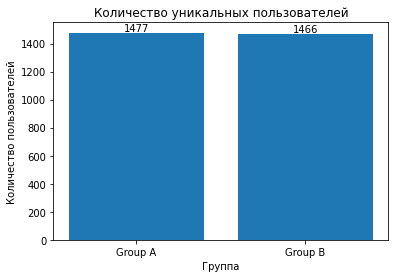

In [8]:
# Загрузка данных из CSV-файла в DataFrame
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Подсчёт количества уникальных пользователей в группе A
unique_users_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()

# Подсчёт количества уникальных пользователей в группе B
unique_users_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

# Расчёт процентной разницы между количеством уникальных пользователей в группах A и B
P = 100 * abs(unique_users_A - unique_users_B) / unique_users_A
print(f"Процентная разница: {round(P,2)}%")

# Построение столбчатой диаграммы для визуализации количества уникальных пользователей в каждой группе
plt.bar(['Group A', 'Group B'], [unique_users_A, unique_users_B])
plt.title('Количество уникальных пользователей')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')

# Определяем словарь с количествами пользователей для каждой группы
group_user_counts = {'Group A': unique_users_A, 'Group B': unique_users_B}

# Добавляем подписи на график с использованием цикла
for i, v in enumerate(group_user_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [9]:
# Подсчёт уникальных пользователей в группе A
users_A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])

# Подсчёт уникальных пользователей в группе B
users_B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

# Нахождение пересечения пользователей
common_users = users_A.intersection(users_B)

# Проверка наличия общих пользователей
if common_users:
    print(f"Количество пользователей, встречающихся в обеих группах: {len(common_users)}")
else:
    print("Нет пользователей, которые встречаются в обеих группах.")


Нет пользователей, которые встречаются в обеих группах.


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


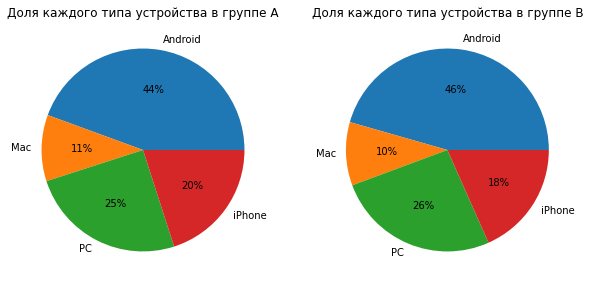

In [10]:
# Группировка данных по группам и типам устройств
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique()
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique()

# Построение диаграммы для группы A
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(group_A, labels=group_A.index, autopct='%.0f%%')
plt.title('Доля каждого типа устройства в группе A')

# Построение диаграммы для группы B
plt.subplot(1, 2, 2)
plt.pie(group_B, labels=group_B.index, autopct='%.0f%%')
plt.title('Доля каждого типа устройства в группе B')

plt.show()


#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


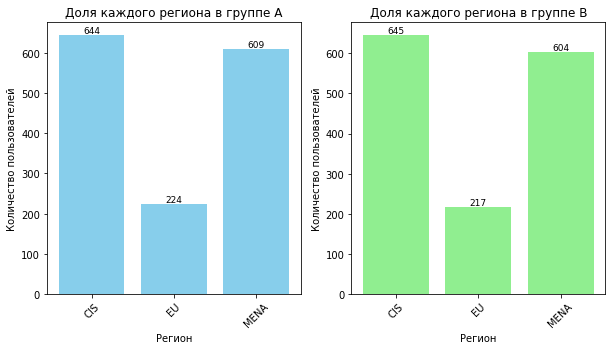

In [11]:
# Группировка данных по группам и регионам
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique()
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique()

# Построение диаграммы для группы A
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(group_A.index, group_A.values, color='skyblue')
plt.title('Доля каждого региона в группе A')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)

# Добавляем подписи значений для группы A
for i, v in enumerate(group_A.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)

# Построение диаграммы для группы B
plt.subplot(1, 2, 2)
plt.bar(group_B.index, group_B.values, color='lightgreen')
plt.title('Доля каждого региона в группе B')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)

# Добавляем подписи значений для группы B
for i, v in enumerate(group_B.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)

plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

На основе предоставленных данных можно сделать следующие выводы:
Различие в количестве пользователей в двух группах: разница составляет всего 0.78%, что указывает на хорошую сбалансированность групп. Это положительно сказывается на корректности A/B-теста.
Независимость выборок: выборки независимы, что является необходимым условием для корректного проведения A/B-теста и интерпретации его результатов.
Распределение пользователей по категориальным переменным (устройства, регионы): равномерное распределение по устройствам и регионам также свидетельствует о качественной организации теста, так как минимизирует влияние внешних факторов на результаты.
Заключение: на основании предоставленных данных можно сказать, что A/B-тест проходит корректно, без видимых нарушений. Все ключевые условия для надёжного тестирования соблюдены, что позволяет продолжить анализ и интерпретацию результатов.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [12]:
# Загрузка данных из CSV-файла в DataFrame
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Добавление 'good_session' с использованием np.where()
sessions_test['good_session'] = np.where(sessions_test['page_counter'] >= 4, 1, 0)


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [13]:
# Преобразование столбца session_date в формат datetime
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])

# Подсчёт количества уникальных пользователей
unique_test_count = sessions_test['user_id'].nunique()

# Находим минимальное и максимальное значения даты
min_test_date = sessions_test['session_date'].min()
max_test_date = sessions_test['session_date'].max()

# Отображение количества уникальных пользователей и период
print("Количество уникальных пользователей:", unique_test_count)
print(f"Период A/B-теста: с {min_test_date.strftime('%Y-%m-%d')} по {max_test_date.strftime('%Y-%m-%d')} ({(max_test_date - min_test_date).days} дней)")


Количество уникальных пользователей: 30579
,Период A/B-теста: с 2025-10-14 по 2025-11-02 (19 дней)


In [14]:
# Преобразование столбца с датой в datetime
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])

# Группировка данных по дате и подсчет уникальных сессий
sessions_grouped = sessions_test.groupby(['session_date', 'test_group'])['user_id'].nunique().reset_index()

# Разделение данных по группам
group_a = sessions_grouped[sessions_grouped['test_group'] == 'A']['user_id']
group_b = sessions_grouped[sessions_grouped['test_group'] == 'B']['user_id']

# Применение t-теста для проверки равенства средних
t_stat, p_value = ttest_ind(group_a, group_b)

print(f"Значение p-value: {round(p_value,2)}")


Значение p-value: 0.95


Различия между количеством уникальных сессий в двух группах не являются статистически значимыми. Обе группы ведут себя одинаково.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [15]:
# Группируем данные по группе и считаем долю успешных сессий
group_a_success_rate = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
group_b_success_rate = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()

# Разница в доле успешных сессий между группами
difference = group_b_success_rate - group_a_success_rate

print(f"Доля успешных сессий в группе A: {round(group_a_success_rate,3)}")
print(f"Доля успешных сессий в группе B: {round(group_b_success_rate,3)}")
print(f"Разница в доле успешных сессий: {round(difference,3)}")


Доля успешных сессий в группе A: 0.308
,Доля успешных сессий в группе B: 0.318
,Разница в доле успешных сессий: 0.011


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [16]:
# Подсчитываем количество успешных сессий и общее количество сессий для каждой группы
success_count_A = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_count_A = len(sessions_test[sessions_test['test_group'] == 'A'])

success_count_B = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_count_B = len(sessions_test[sessions_test['test_group'] == 'B'])

alpha = 0.05  # уровень значимости

# Проводим z-тест для сравнения долей
stat_ztest, p_value_ztest = proportions_ztest(
    [success_count_A, success_count_B],
    [total_count_A, total_count_B],
    alternative='two-sided'  # проверяем двустороннюю гипотезу
)

print(f"Статистика теста: {round(stat_ztest,4)}")
print(f"P-значение: {round(p_value_ztest,4)}")

if p_value_ztest > alpha:
    print(f'pvalue={round(p_value_ztest,4)} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={round(p_value_ztest,4)} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

Статистика теста: -3.6027
,P-значение: 0.0003
,pvalue=0.0003 < 0.05
,Нулевая гипотеза не находит подтверждения!


Результаты теста говорят о том, что различия в долях успешных сессий между группами A и B статистически значимы, и можно предположить, что доли успешных сессий действительно различаются.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

На основе проведённого анализа можно сделать следующие выводы для команды разработки приложения:

Характеристики проведённого эксперимента: сравнивались похожие группы пользователей с успешными сессиями (более 4 посещённых страниц). Алгоритм, который тестировался, связан с взаимодействиями на сайте. Количество задействованных пользователей: 30 579. Длительность эксперимента: 19 дней.

Влияние внедрения нового алгоритма рекомендаций на рост ключевой метрики: ключевая метрика увеличилась.
Значение p-value для оценки статистической значимости выявленного эффекта: p-value составляет 0,0003, что значительно меньше выбранного уровня значимости (0,05). Это означает, что наблюдаемое увеличение метрики является статистически значимым и не может быть результатом случайной вариации данных.

Решение о внедрении нововведения в алгоритм приложения: на основании полученных результатов есть достаточные доказательства для утверждения о наличии значимого положительного эффекта от внедрения нового алгоритма. Поэтому внедрение нововведения в алгоритм рекомендаций может быть целесообразным.